### **Import needed libraries**

In [1]:
import json
import os
import cv2
import shutil
from skimage.transform import resize
from functools import partial
import tensorflow as tf
import keras
import numpy as np
import mediapipe as mp
from scipy.ndimage import gaussian_filter, median_filter, sobel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import (
    Resizing,
    Rescaling,
    Lambda,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomTranslation,
    MaxPooling2D,
    MaxPooling3D,
    Conv2D,
    ConvLSTM2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    Dropout, Input, TimeDistributed, LSTM, BatchNormalization, Activation
)
from matplotlib.image import imread
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [2]:
from functions_ml import refactor_video_into_input

In [3]:
tf.__version__

'2.8.3'

In [4]:
tf.random.set_seed(420)

In [5]:
IMAGE_SIZE = (256, 256)
SEQUENCE_LENGTH = 25
BG_COLOR = (255, 255, 255)

In [6]:
path_to_folder_with_videos =  "sign_language_videos"
path_to_folder_with_videos

'sign_language_videos'

In [7]:
mp_selfie_segmentation = mp.solutions.selfie_segmentation
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [8]:
def mediapipe_detection(image, model):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [9]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [10]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

### **Load json data about videos**

In [11]:
with open('videos_json_data.json', 'r') as f:
    data = json.load(f)

### **Classes**

In [12]:
chosen_words = ['what', 'hello', 'love', 'please', 'thank you']

### **Extract videos' needed indexes**

In [13]:
videos_indexes_dict = {}
for index, word_dict in enumerate(data):
    if word_dict['gloss'] in chosen_words:
        videos_indexes_dict[word_dict['gloss']] = [word_dict['instances'][i]['video_id'] for i in range(len(word_dict['instances']))]

In [14]:
videos_indexes_dict

{'what': ['62944',
  '69531',
  '68330',
  '62967',
  '62968',
  '62982',
  '62970',
  '62984',
  '62971',
  '66769',
  '67057',
  '62986',
  '62973',
  '62987',
  '62964',
  '67058',
  '62988',
  '62975',
  '62965',
  '62979',
  '62966'],
 'please': ['43213',
  '69434',
  '70220',
  '68670',
  '43225',
  '43226',
  '43217',
  '67083',
  '43218',
  '43219',
  '43220',
  '43221',
  '43222',
  '43223',
  '43224'],
 'thank you': ['57653',
  '69502',
  '68796',
  '57663',
  '57664',
  '66598',
  '57655',
  '57665',
  '57666',
  '57667',
  '57656',
  '57657',
  '57658',
  '57659'],
 'hello': ['27171',
  '70017',
  '68236',
  '27180',
  '67755',
  '27181',
  '27182',
  '27183',
  '27184',
  '27172',
  '27173',
  '27175',
  '27177'],
 'love': ['34118',
  '34123',
  '34124',
  '34125',
  '34127',
  '34128',
  '34129',
  '34121',
  '34133',
  '34134',
  '34136',
  '34137']}

### **Move new videos to target directory and fill in our dict with indexes**

In [15]:
with open("our_videos_indexes.json", "r") as f2:

    try:
        data = json.load(f2)
    except json.JSONDecodeError:
        data = {}

    for label in os.listdir('our_videos_CV'):
        for video in os.listdir(os.path.join('our_videos_CV', label)):

            if not os.path.exists(os.path.join(path_to_folder_with_videos, video)):
                shutil.move(os.path.join('our_videos_CV', label, video), os.path.join(path_to_folder_with_videos, video))

            if not data.get(label):
                data[label] = []

            if video not in data[label]:
                data[label].append(video.split(".")[0])

    for label, indexes in data.items():
        
        try:
            videos_indexes_dict[label].extend(indexes)
        except KeyError:
            continue
        
with open("our_videos_indexes.json", "w") as f3:
    new_data = json.dump(data, f3)

In [16]:
videos_indexes_dict

{'what': ['62944',
  '69531',
  '68330',
  '62967',
  '62968',
  '62982',
  '62970',
  '62984',
  '62971',
  '66769',
  '67057',
  '62986',
  '62973',
  '62987',
  '62964',
  '67058',
  '62988',
  '62975',
  '62965',
  '62979',
  '62966',
  '0006_Michal_what',
  '0003_Marcin_what',
  '0004_Stefan_what',
  'IMG_7109',
  'IMG_7107',
  'IMG_7105',
  'IMG_7102',
  'IMG_7100',
  'IMG_7097',
  '0001_Piotrek',
  '0002_Piotrek',
  '0030_Pawel',
  '315660794_5737330542972529_3137644611967061033_n',
  '315667298_5538013912980151_8041855435225314858_n',
  '315676582_8325811004158012_7358575957107178723_n',
  '315681772_5839689206092977_4388615138539721863_n',
  '315975200_5119105354855696_7130324827507709116_n',
  '316177093_5893836614012038_8296374439895096079_n',
  '316241148_8209053445832037_7699394294060366883_n',
  '316324152_8218071561599820_4430118803425937420_n',
  '316364046_5978836185484130_1501040512796179661_n',
  '316378055_9028406133839871_434044695211354231_n',
  '316383479_5599256

### **Chosing only these which are not present in missing.txt**

In [17]:
with open('missing.txt', 'r') as miss:
    missing_indexes = miss.readlines()
    missing_indexes = [index.strip() for index in missing_indexes]

In [18]:
cleared_videos_indexes_dict = {label: list(set(label_indexes).difference(set(missing_indexes))) for label, label_indexes in videos_indexes_dict.items()}

In [19]:
def delete_unused_videos(used_video_indexes, path_to_folder_with_videos):

    used_videos = []

    for label, videos_indexes in used_video_indexes.items():
        used_videos.extend(list(videos_indexes))

    for video_name in os.listdir(path_to_folder_with_videos):
        if video_name.split('.')[0] not in used_videos:
            os.remove(os.path.join(path_to_folder_with_videos, video_name))

In [20]:
def begin_and_end(number: int):

    if number == 1:
        return 1, 0
    
    if number % 2 == 0:
        from_beginning, from_ending = number / 2, number / 2
    else:
        from_beginning, from_ending = number // 2 + 1, number // 2

    return int(from_beginning), int(from_ending)

In [21]:
def get_canny_frame(frame, apply_median_filter=True, filter_power=6):

    if apply_median_filter:
        frame = median_filter(frame, filter_power)
            
    return cv2.Canny(frame, 100, 200)

In [22]:
def remove_background(mp_selfie_segmentation, frame, background_color):

    with mp_selfie_segmentation.SelfieSegmentation(model_selection=1) as selfie_segmentation:

        image = cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = selfie_segmentation.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1

        background = np.zeros(image.shape, dtype=np.uint8)
        background[:] = background_color
        
        output_image = cv2.flip(np.where(condition, image, background), 1)

    return output_image

In [23]:
def extract_keypoints(results):

    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, lh, rh])

### **Getting frames from chosen videos**

In [24]:
keypoints_or_photos = "chosen_keypoints"

In [25]:
if os.path.exists(keypoints_or_photos):
    shutil.rmtree(keypoints_or_photos)
    
if not os.path.exists(keypoints_or_photos):
    os.mkdir(keypoints_or_photos)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for label, label_indexes in cleared_videos_indexes_dict.items():

        if not os.path.exists(f'{keypoints_or_photos}/{label}'):
            os.mkdir(f'{keypoints_or_photos}/{label}')

        for video_index in label_indexes:

            path_to_video = f'{path_to_folder_with_videos}/{video_index}.mp4'
            if not os.path.exists(path_to_video):
                print(f'{path_to_video} does not exist!')
                continue
            
            capture = cv2.VideoCapture(path_to_video)
            video_length = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            
            step = max(round(video_length / SEQUENCE_LENGTH, 0), 1)

            video_frames = []
            success, frame = capture.read()
            frame_nr = 1
            counter = 1

            while success:
                success, frame = capture.read()

                if success and counter % step == 0: 
                    
                    video_frames.append(frame)
                    frame_nr += 1

                counter += 1

            if len(video_frames) != 25:
                
                if len(video_frames) > 25:
                    excess = len(video_frames) - 25
                    from_beginning, from_ending = begin_and_end(excess)
                    video_frames = video_frames[from_beginning:-from_ending]

                else:
                    shortage = 25 - len(video_frames)
                    black_image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.uint8)
                    from_beginning, from_ending = begin_and_end(shortage)
                    video_frames = [black_image] * from_beginning + video_frames + [black_image] * from_ending

            if len(video_frames) != 25:
                continue
            
            for frame_index, frame in enumerate(video_frames, start=1):
                path_to_frame = f'{keypoints_or_photos}/{label}/{video_index}-{frame_index}.jpg'

                if not os.path.exists(path_to_frame):
                    
                    # frame = remove_background(mp_selfie_segmentation, frame, BG_COLOR)
                    resized_frame = cv2.resize(frame, IMAGE_SIZE)
                    image, results = mediapipe_detection(resized_frame, holistic)
                    # draw_styled_landmarks(image, results)

                    keypoints = extract_keypoints(results)
                    np.save(path_to_frame, keypoints)

                    # grayscale_resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
                    # canny_frame = get_canny_frame(grayscale_resized_frame)
                    # cv2.imwrite(path_to_frame, canny_frame)

            capture.release()

sign_language_videos/0006_Michal_what.mp4 does not exist!
sign_language_videos/62988.mp4 does not exist!
sign_language_videos/62966.mp4 does not exist!
sign_language_videos/0004_Stefan_what.mp4 does not exist!
sign_language_videos/62967.mp4 does not exist!
sign_language_videos/66769.mp4 does not exist!
sign_language_videos/62979.mp4 does not exist!
sign_language_videos/340658154_5893154924146322_5155817223749003930_n.mp4 does not exist!
sign_language_videos/315662831_5569278169807369_7956799844279816859_n.mp4 does not exist!
sign_language_videos/340535036_6888430721184473_9171627785236476579_n.mp4 does not exist!
sign_language_videos/315666482_8215949598478577_5448997221380429303_n.mp4 does not exist!
sign_language_videos/0005_Michal_please.mp4 does not exist!
sign_language_videos/66598.mp4 does not exist!
sign_language_videos/57657.mp4 does not exist!
sign_language_videos/57655.mp4 does not exist!
sign_language_videos/69502.mp4 does not exist!
sign_language_videos/57656.mp4 does not e

### **How many instances of each class**

In [26]:
for label, indexes in cleared_videos_indexes_dict.items():
    print(f"{label} - {len(indexes)} instances")

what - 53 instances
please - 65 instances
thank you - 59 instances
hello - 53 instances
love - 53 instances


In [27]:
cleared_videos_indexes_dict

{'what': ['324408079_8471771102894175_990846606789254112_n',
  '323697667_6076253762426225_254042038517677181_n',
  '316383479_5599256033502082_5209859571358498713_n',
  '0006_Michal_what',
  'IMG_7107',
  '316241148_8209053445832037_7699394294060366883_n',
  'IMG_7105',
  'IMG_7109',
  '325019297_5504335286361222_6562463292790795922_n',
  '315676582_8325811004158012_7358575957107178723_n',
  '322648811_8840867659258518_5351382910370225924_n',
  '316177093_5893836614012038_8296374439895096079_n',
  '324935351_6200301796725763_6125128107224708014_n',
  '0030_Pawel',
  '62987',
  '69531',
  '0002_Piotrek',
  '315667298_5538013912980151_8041855435225314858_n',
  '316364046_5978836185484130_1501040512796179661_n',
  '0003_Marcin_what',
  '62988',
  '315681772_5839689206092977_4388615138539721863_n',
  '62970',
  '316479359_5300582020047246_3819302706393631278_n',
  '323796240_5753068901454205_88050558482957590_n',
  '323419158_8457587544312037_3897155433870380465_n',
  '323450666_886337505

In [28]:
if os.path.exists(f'splitted'):
    shutil.rmtree('splitted')

In [29]:
if not os.path.exists(f'splitted'):
    os.mkdir(f'splitted')

for dataset in ['train', 'val', 'test']:
    if not os.path.exists(f'splitted/{dataset}'):
        os.mkdir(f'splitted/{dataset}')

### **Create train, test, validation directories of photos divided also by class**

In [30]:
for label, samples in cleared_videos_indexes_dict.items():

    train_set, test_set = train_test_split(list(samples), train_size=0.85)
    train_set, validation_set = train_test_split(train_set, test_size=0.15)

    for dataset_name in ['train', 'test', 'val']:
        if not os.path.exists(f'splitted/{dataset_name}/{label}'):
            os.mkdir(f'splitted/{dataset_name}/{label}')

    for image in os.listdir(f'{keypoints_or_photos}/{label}'):
        image_index = image.split('-')[0]

        for dataset, dataset_name in zip([train_set, validation_set, test_set], ['train', 'val', 'test']):
            if image_index in dataset:
               shutil.copyfile(os.path.join(keypoints_or_photos, label, image), os.path.join('splitted', dataset_name, label, image)) 

In [131]:
def data_augmentation_from_keras():
    """
        It creates several layers of preprocessing data.
        return: data_augmentation
    """

    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.1),
        RandomTranslation(0.1, 0.1)
    ])

    return data_augmentation

In [132]:
def augmented_sample(train_dataset):
    """
        Function which takes one photo from train dataset randomly,
        applies augmentation on it and returns list of augmented images
        train_dataset: batched train data set
        return: list of images of augmented photo
    """

    augmented_photos = []
    data_augmentation = data_augmentation_from_keras()

    for images, _ in train_dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            augmented_photos += [augmented_images[0]]

    return augmented_photos

In [31]:
classes_dict = {name: i for i, name in enumerate(os.listdir(keypoints_or_photos))}
classes_dict

{'hello': 0, 'love': 1, 'please': 2, 'thank you': 3, 'what': 4}

### **Creating train, test and validation sets with tensors**

In [32]:
x_train, y_train, x_val, y_val, x_test, y_test = [], [], [], [], [], []
for dataset_name, x_dataset, y_dataset in zip(['train', 'val', 'test'], [x_train, x_val, x_test], [y_train, y_val, y_test]):
    for label in os.listdir(os.path.join('splitted', dataset_name)):
        one_video = []
        for counter, image_path in enumerate(os.listdir(os.path.join('splitted', dataset_name, label)), start=1):

            if keypoints_or_photos == "chosen_keypoints":
                one_video.append(np.load(os.path.join('splitted', dataset_name, label, image_path)))
            else:
                one_video.append(imread(os.path.join('splitted', dataset_name, label, image_path)))
                
            if counter % 25 == 0:
                x_dataset.append(np.asarray(one_video).reshape(25, -1))
                y_dataset.append(classes_dict[label])
                one_video.clear()
                
x_train, x_val, x_test = np.asarray(x_train), np.asarray(x_val), np.asarray(x_test)
y_train, y_val, y_test = np.asarray(y_train, dtype=np.float32), np.asarray(y_val, dtype=np.float32), np.asarray(y_test, dtype=np.float32)

In [33]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [34]:
def reshape_set(dataset):

    shape = list(dataset.shape) + [1]
    dataset = dataset.reshape(tuple(shape))
    
    return dataset

In [39]:
y_train, y_val, y_test = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)

In [40]:
x_train, x_val, x_test = tf.cast(x_train, tf.float32), tf.cast(x_val, tf.float32), tf.cast(x_test, tf.float32)
y_train, y_val, y_test = tf.cast(y_train, tf.float32), tf.cast(y_val, tf.float32), tf.cast(y_test, tf.float32)

In [41]:
x_train.shape, x_val.shape, x_test.shape

(TensorShape([170, 25, 258]),
 TensorShape([32, 25, 258]),
 TensorShape([33, 25, 258]))

### **Build a model**

In [49]:
def build_convlstm_model(input_shape, units):

    DefaultConvLSTM2D = partial(tf.keras.layers.ConvLSTM2D,
                                kernel_size=(3, 3), 
                                padding="same",
                                activation="relu", 
                                kernel_initializer="he_normal", 
                                data_format='channels_last', 
                                recurrent_dropout=0.23,
                                return_sequences=True)
    
    DefaultConv2D = partial(tf.keras.layers.Conv2D,
                                kernel_size=(3, 3),
                                padding="same",
                                strides=(2, 2),
                                kernel_initializer="he_normal", 
                                data_format='channels_last')
    

    model = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1. / 255),

            DefaultConvLSTM2D(filters=8, input_shape=input_shape),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.3)),

            DefaultConvLSTM2D(filters=16),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.3)),

            # DefaultConvLSTM2D(filters=12),
            # MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            # TimeDistributed(Dropout(0.2)),
            
            # TimeDistributed(DefaultConvLSTM2D(filters=64)),
            # TimeDistributed(MaxPooling2D((2, 2), padding='same', data_format='channels_last')),
            #TimeDistributed(BatchNormalization()),

            # TimeDistributed(DefaultConv2D(64)),
            # TimeDistributed(BatchNormalization()),
            # TimeDistributed(Activation('elu')),

            # TimeDistributed(DefaultConv2D(64)),
            # TimeDistributed(BatchNormalization()),
            # TimeDistributed(Activation('elu')),

            Flatten(),
            Dense(units, activation='softmax')

        ])

    return model

In [36]:
def build_lcrn_model():

    DefaultConv2D = partial(tf.keras.layers.Conv2D,
                            kernel_size=(3, 3), 
                            padding="same",
                            activation="relu", 
                            data_format='channels_last')
    
    DefaultConv3D = partial(tf.keras.layers.Conv3D,
                                kernel_size=(3, 3, 3), 
                                padding="same",
                                activation="relu", 
                                data_format='channels_last')

    DefaultMaxPool2D = partial(MaxPooling2D((2, 2), padding='same', data_format='channels_last'))
    # DefaultMaxPool3D = partial(MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'))

    model = tf.keras.Sequential([
            Rescaling(1. / 255),

            TimeDistributed(DefaultConv2D(filters=8, input_shape=(25, 160, 160, 3))),
            TimeDistributed(MaxPooling2D((2, 2), padding='same', data_format='channels_last')),
            # MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),

            # DefaultConv3D(filters=32),
            # DefaultConv3D(filters=32),
            # MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            # TimeDistributed(Dropout(0.25)),

            TimeDistributed(DefaultConv2D(filters=16)),
            TimeDistributed(DefaultConv2D(filters=16)),
            TimeDistributed(MaxPooling2D((2, 2), padding='same', data_format='channels_last')),
            TimeDistributed(Dropout(0.2)),

            TimeDistributed(DefaultConv2D(filters=32)),
            TimeDistributed(DefaultConv2D(filters=32)),
            TimeDistributed(MaxPooling2D((2, 2), padding='same', data_format='channels_last')),
            TimeDistributed(Dropout(0.2)),

            TimeDistributed(DefaultConv2D(filters=64)),
            TimeDistributed(DefaultConv2D(filters=64)),
            TimeDistributed(MaxPooling2D((2, 2), padding='same', data_format='channels_last')),
            # tf.keras.layers.TimeDistributed(Dropout(0.25)),

            TimeDistributed(Flatten()),
            LSTM(32, name='lstm_1'),
            # Dropout(0.4),
            # tf.keras.layers.LSTM(32),

            Dense(units=1, activation="sigmoid")

        ])

    return model

In [57]:
def lstm_model(input_shape, units):

    model = tf.keras.Sequential([
            LSTM(16, return_sequences=True, activation='relu', input_shape=input_shape, recurrent_dropout=0.2),
            LSTM(32, return_sequences=True, activation='relu', recurrent_dropout=0.2),
            LSTM(16, return_sequences=False, activation='relu', recurrent_dropout=0.2),
            Dense(24, activation='elu'),
            Dropout(0.25),
            Dense(12, activation='elu'),
            Dropout(0.25),
            Dense(units=units, activation="softmax")
        ])

    return model
    

### **Set hyperparams and needed callbacks**

In [58]:
lstm_model = lstm_model(input_shape=(SEQUENCE_LENGTH, x_train.shape[-1]), units=5)

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000045), #choosing optimizer
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #loss function
                    metrics=['categorical_accuracy']) 

# path_to_convlstm_model = os.path.join('models', 'lstm_more_data.ckpt')
path_to_convlstm_history = os.path.join('models', 'lstm_5_classes.csv')

n_epochs = 500
callbacks = [EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
             CSVLogger(path_to_convlstm_history, append=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25)]

### **Train model**

In [59]:
conv3_model_history = lstm_model.fit(  x=x_train,
                                        y=y_train,
                                        validation_data=(x_val, y_val),
                                        epochs=n_epochs,
                                        batch_size=12,
                                        workers=-1,
                                        use_multiprocessing=True,
                                        callbacks = callbacks
                                        )

Epoch 1/500
15/15 [==============================] - 4s 59ms/step - loss: 1.6138 - categorical_accuracy: 0.2412 - val_loss: 1.6122 - val_categorical_accuracy: 0.3438 - lr: 4.5000e-05
Epoch 2/500
15/15 [==============================] - 0s 28ms/step - loss: 1.6128 - categorical_accuracy: 0.2118 - val_loss: 1.6106 - val_categorical_accuracy: 0.3438 - lr: 4.5000e-05
Epoch 3/500
15/15 [==============================] - 0s 28ms/step - loss: 1.6192 - categorical_accuracy: 0.2059 - val_loss: 1.6099 - val_categorical_accuracy: 0.3750 - lr: 4.5000e-05
Epoch 4/500
15/15 [==============================] - 0s 29ms/step - loss: 1.6141 - categorical_accuracy: 0.2118 - val_loss: 1.6090 - val_categorical_accuracy: 0.3750 - lr: 4.5000e-05
Epoch 5/500
15/15 [==============================] - 0s 29ms/step - loss: 1.6051 - categorical_accuracy: 0.1941 - val_loss: 1.6079 - val_categorical_accuracy: 0.3438 - lr: 4.5000e-05
Epoch 6/500
15/15 [==============================] - 0s 32ms/step - loss: 1.6155 - ca

In [60]:
lstm_model.save('models/lstm_5_classes.ckpt')

INFO:tensorflow:Assets written to: models/lstm_5_classes.ckpt\assets


2023-04-17 21:33:56,657 Assets written to: models/lstm_5_classes.ckpt\assets
2023-04-17 21:33:56,817 <keras.layers.recurrent.LSTMCell object at 0x0000027969112FD0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2023-04-17 21:33:56,817 <keras.layers.recurrent.LSTMCell object at 0x000002796910B6D0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2023-04-17 21:33:56,817 <keras.layers.recurrent.LSTMCell object at 0x0000027969120940> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <cl

In [61]:
path_to_model = os.path.join('models', 'lstm_5_classes.ckpt')

In [62]:
trained_model = tf.keras.models.load_model(path_to_model)

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

model_learning_data = pd.read_csv("models/lstm_5_classes.csv")
model_learning_data
# fig, ax = plt.subplots(figsize=(20, 15))
# ax.scatter(x=model_learning_data['epoch'], y=model_learning_data['loss'])
# ax.scatter(x=model_learning_data['epoch'], y=model_learning_data['val_loss'])


,epoch,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0,0.241176,1.613844,0.34375,1.612229
1,1,0.211765,1.612768,0.34375,1.610618
2,2,0.205882,1.619174,0.37500,1.609889
3,3,0.211765,1.614052,0.37500,1.609004
4,4,0.194118,1.605055,0.34375,1.607940
...,...,...,...,...,...
495,495,0.935294,0.236288,0.90625,0.193005
496,496,0.882353,0.251174,0.90625,0.172108
497,497,0.917647,0.238201,0.93750,0.166189
498,498,0.923529,0.221693,0.93750,0.164368


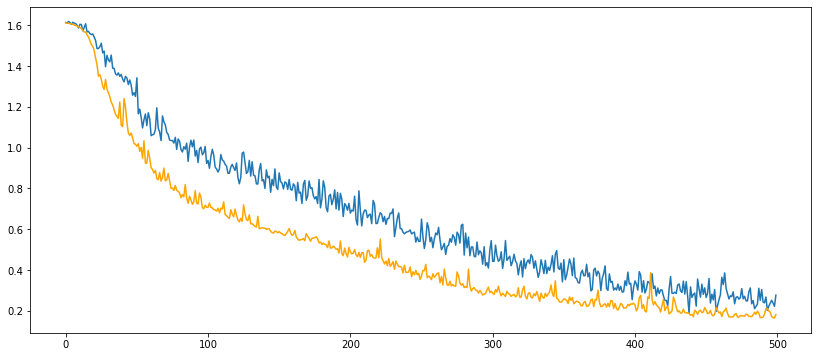

In [65]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(model_learning_data['epoch'], model_learning_data['loss'])
ax.plot(model_learning_data['epoch'], model_learning_data['val_loss'], color='orange')
plt.show()

### **Predictions**

In [66]:
test_preds = lstm_model.predict(x_test)
train_preds = lstm_model.predict(x_train)
val_preds = lstm_model.predict(x_val)

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [69]:
accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_preds, axis=1))

0.9823529411764705

In [70]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_preds, axis=1))

0.90625

In [71]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_preds, axis=1))

0.9090909090909091

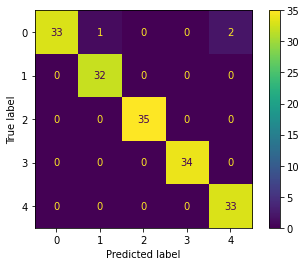

In [72]:
train_cm = ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_preds, axis=1)))
train_cm.plot()
plt.show()

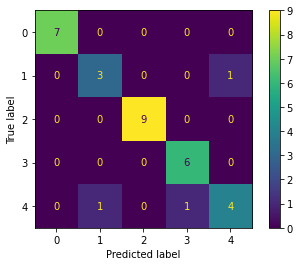

In [73]:
val_cm = ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_val, axis=1), np.argmax(val_preds, axis=1)))
val_cm.plot()
plt.show()

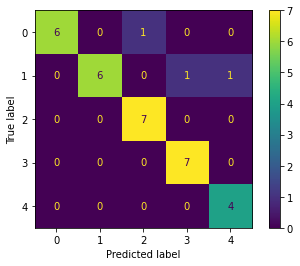

In [74]:
test_cm = ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_preds, axis=1)))
test_cm.plot()
plt.show()

In [82]:
test_preds_treshold = [1 if pred >= 0.5 else 0 for pred in test_preds]
train_preds_treshold = [1 if pred >= 0.5 else 0 for pred in train_preds]
val_preds_treshold = [1 if pred >= 0.5 else 0 for pred in val_preds]

In [61]:
def manual_accuracy(predictions, real_values):
    acc = round(sum([1 if pred == real else 0 for pred, real in zip(predictions, real_values)]) / len(real_values), 3)
    return acc

In [62]:
manual_accuracy(test_preds_treshold, y_test), manual_accuracy(train_preds_treshold, y_train), manual_accuracy(val_preds_treshold, y_val)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()